**Description** Distributions of marginal effects. These plots are much easier to
interpret than ones about $\beta$. In other words, the distributions of—

$$
\begin{align*}
\frac{\bar{\hat{Y}}_{\cdot \cdot \cdot 1} - \bar{\hat{Y}}_{\cdot \cdot \cdot 0}}{n}
\end{align*}
$$

—the difference between the treatment ($1$) and control ($0$) grand means. The mean is
taken across LM types, classification tasks, and their subsamples. We could produce
conditional plots for each of these groups, but rn I want to summarize the results.

**Required data**: posterior samples are stored in `main_*.nc` files. Obtain them by
running the notebooks in [`../fit_posteriors/`](../fit_posteriors/). Unfortunately all
of the inference data was saved (including for parameters we don't care about), so these
files are in the 10s of GBs. I'm trying to find a cheap and long-term way to share
these. Sorry.

**Estimated runtime**: 2 min.

In [1]:
import os
import sys
from typing import Literal

import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import polars as pl
import seaborn as sns
from tqdm.auto import tqdm

# sys hack to import from parent
sys.path.append(os.path.abspath(os.path.join('..')))
import utils

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
sns.set_theme(style="darkgrid")

In [3]:
effect_to_name: dict[str, str] = {
    "control": "pretraining boost",
    "treatment": "evaluation bias",
}

# Input

In [4]:
num_train: Literal[50, 100] = 100

In [5]:
thingy: Literal["regular", "zero_shot", "gpt2-epochs-2"] = "regular"

_plot_title = f"$m={{{num_train}}}$ training observations"

if thingy == "regular":
    num_tests: tuple[int] = (50, 100, 200, 500)
    accuracies_home_dir: str = os.path.join("..", "accuracies_from_paper")
    netcdfs_path: str = os.path.join("..", "netcdfs")
    title = _plot_title
elif thingy == "zero_shot":
    num_tests: tuple[int] = (100,)
    accuracies_home_dir: str = os.path.join("..", "accuracies_zero_shot")
    netcdfs_path: str = os.path.join("..", "netcdfs", "zero-shot")
    title = "Mistral 7B, zero-shot"
elif thingy == "gpt2-epochs-2":
    num_tests: tuple[int] = (50,)
    accuracies_home_dir: str = os.path.join("..", "accuracies_gpt2_epochs_2")
    netcdfs_path: str = os.path.join("..", "netcdfs", "gpt2-epochs-2")
    title = f"{_plot_title} (overtraining)"
else:
    raise ValueError("Not a valid thingy")

# Marginalize

In [6]:
num_test_to_diffs_df: dict[int, pl.DataFrame] = {}
for num_test in tqdm(num_tests, "Processing treatment and control datasets"):
    num_correct_df = utils.load_all_num_correct(
        os.path.join(accuracies_home_dir, f"m{num_train}"), num_test
    )
    effect_to_diffs_df = {}
    for effect in effect_to_name:
        az_summary = az.from_netcdf(
            os.path.join(
                netcdfs_path,
                f"m{num_train}",
                f"main_m{num_train}_n{num_test}_{effect}.nc",
            )
        )
        diffs_df = pl.DataFrame(
            utils.posterior_marginal_mean_diffs(az_summary, num_correct_df)
        )
        effect_to_diffs_df[effect] = diffs_df
    num_test_to_diffs_df[num_test] = pl.DataFrame(effect_to_diffs_df)
del az_summary  # do notebooks garbage collect this?

Processing treatment and control datasets:   0%|          | 0/4 [00:00<?, ?it/s]

Marginalizing each draw (n = 50):   0%|          | 0/4000 [00:00<?, ?it/s]

Marginalizing each draw (n = 50):   0%|          | 0/4000 [00:00<?, ?it/s]

Marginalizing each draw (n = 100):   0%|          | 0/4000 [00:00<?, ?it/s]

Marginalizing each draw (n = 100):   0%|          | 0/4000 [00:00<?, ?it/s]

Marginalizing each draw (n = 200):   0%|          | 0/4000 [00:00<?, ?it/s]

Marginalizing each draw (n = 200):   0%|          | 0/4000 [00:00<?, ?it/s]

Marginalizing each draw (n = 500):   0%|          | 0/4000 [00:00<?, ?it/s]

Marginalizing each draw (n = 500):   0%|          | 0/4000 [00:00<?, ?it/s]

# Plot

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


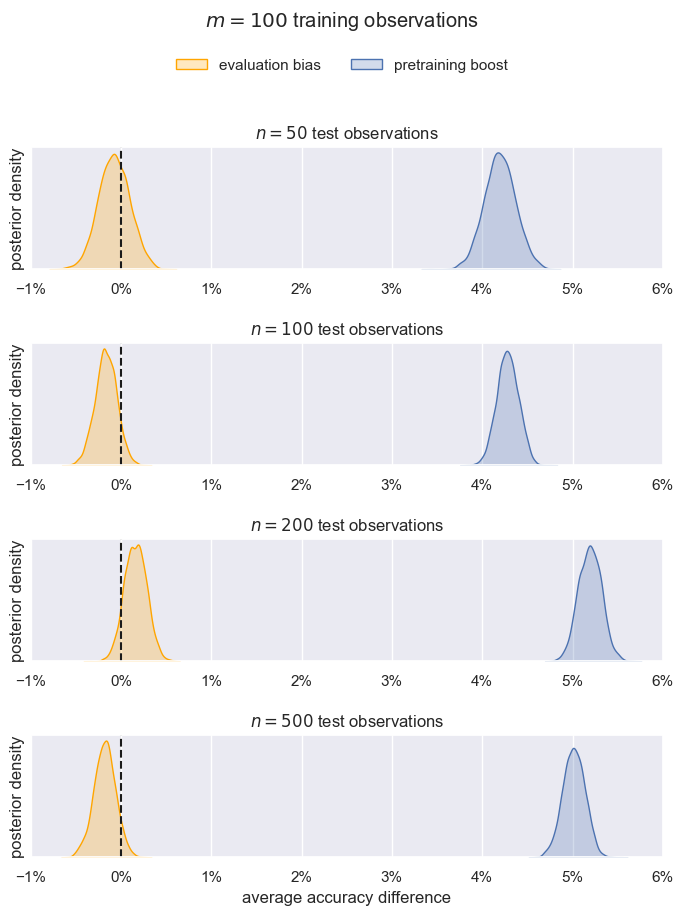

In [7]:
fig, axes = plt.subplots(nrows=len(num_tests), ncols=1)
fig.set_size_inches(7, (2 * len(num_tests)))

if thingy == "regular":
    xlim = (-0.01, 0.06)
elif thingy == "zero_shot":
    xlim = (-0.02, 0.07)
else:
    xlim = (-0.06, 0.01)

xticks = np.arange(xlim[0], xlim[1] + 0.01, 0.01)
# every 0.01

axes: list[plt.Axes] = [axes] if len(num_tests) == 1 else axes
with sns.color_palette(palette=["C0", "orange"]):  # brighter orange to match LaTeX's
    for subplot_idx, (num_test, diffs_df) in enumerate(num_test_to_diffs_df.items()):
        ax = axes[subplot_idx]
        _ = ax.set_xlim(xlim)
        _ = sns.kdeplot(
            ax=ax, data=diffs_df.rename(effect_to_name).to_pandas(), fill=True
        )
        ax.axvline(0, linestyle="dashed", color="k")
        _ = ax.set_ylabel("posterior density")
        _ = ax.set_yticks([])
        _ = ax.set_xticks(xticks)
        ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
        _ = ax.set_title(
            # f"$m={{{num_train}}}$ training observations, "
            f"$n={{{num_test}}}$ test observations"
        )

_ = ax.set_xlabel("average accuracy difference")

title_y_pos = 1.07 if thingy == "regular" else 1.25
fig.suptitle(title, y=title_y_pos)

fig.legend(
    handles=reversed(ax.legend_.legend_handles),
    labels=reversed([t.get_text() for t in ax.legend_.get_texts()]),
    ncol=2,
    loc="center",
    frameon=False,
    bbox_to_anchor=(0.5, 1.0),
)

for ax in axes:
    ax.legend().set_visible(False)

fig.tight_layout()
plt.subplots_adjust(bottom=0.01)

In [8]:
# if thingy == "regular":
#     fig.savefig(
#         os.path.join("figures", f"posterior_pred_m{num_train}.png"), bbox_inches="tight"
#     )
# elif thingy == "zero_shot":
#     fig.savefig(
#         os.path.join("figures", "posterior_pred_zero_shot.png"), bbox_inches="tight"
#     )
# elif thingy == "gpt2-epochs-2":
#     fig.savefig(
#         os.path.join("figures", f"posterior_pred_m{num_train}_gpt2-epochs-2.png"),
#         bbox_inches="tight",
#     )